# Age analysis for TOI 811 and TOI 852

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'legend.fontsize': 15,
           'axes.linewidth': 1,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load kinematic data for the Kepler field.

In [2]:
df = pd.read_csv("../data/bokeh_df.csv")

Load TIC data files for the two BD hosts.

In [5]:
toi_811 = pd.read_csv("data/TICv8_1_TIC_100757807.csv", skiprows=4)
toi_852 = pd.read_csv("data/TICv8_1_TIC_29918916.csv", skiprows=4)

Calculate absolute magnitude for each star.

In [19]:
def abs_mag(m, D):
    return m - 5*np.log10(D) + 5

toi_811_MG = abs_mag(toi_811.GAIAmag, 1./toi_811.plx*1e3)
toi_852_MG = abs_mag(toi_852.GAIAmag, 1./toi_852.plx*1e3)

toi_811_prot = 3.21
toi_852_prot = 5.8

Plot TOI 811 on a Magnitude-Teff diagram and a Period - Teff diagram. The background stars are colored by their kinematic age (see [Angus et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160...90A/abstract)).

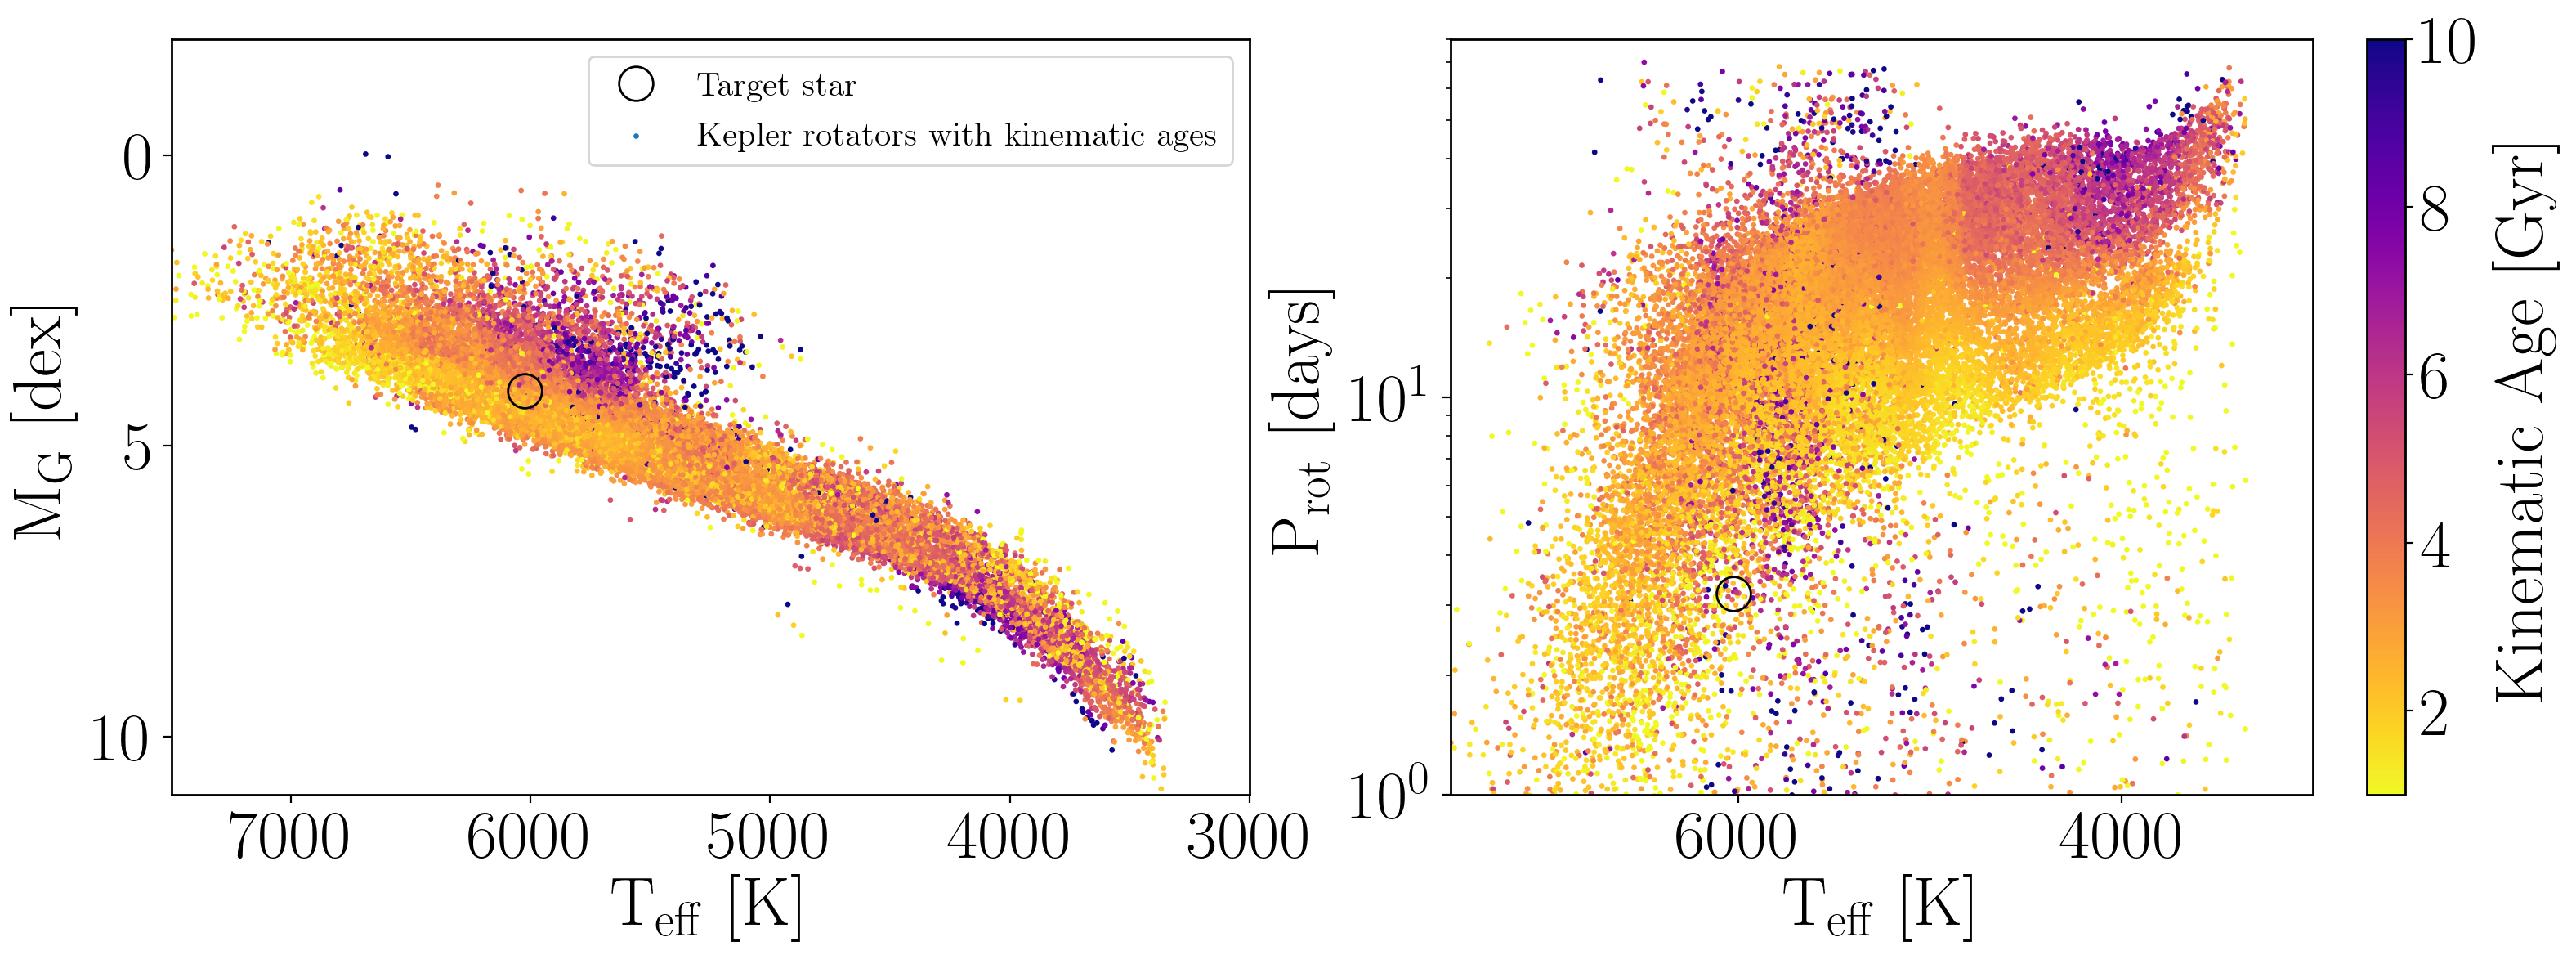

In [83]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.scatter(df.teff, df.M_G, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0, label="$\mathrm{Kepler~rotators~with~kinematic~ages}$")#, alpha=.5)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.plot(toi_811.Teff, toi_811_MG, "o", color="none", mec="k", ms=15, zorder=1, linewidth=10, label="$\mathrm{Target~star}$")
ax1.legend()

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.teff, df.prot, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")
ax2.plot(toi_811.Teff, toi_811_prot, "o", color="none", mec="k", ms=15, zorder=1, linewidth=10)

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

This plot shows that this star has a similar Prot, Teff and absolute Gaia magnitude to stars with **young kinematic ages**.

Let's calculate an age for this star using a gyrochronology model that is based on the Praesepe cluster from [Angus et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....158..173A/abstract). This is one of many different available gyrochronology models and each will give a slightly different age.

In [61]:
import stardate2 as sd2
import emcee

ndim, nwalkers = 1, 25
log_age_init = 8
p0 = np.random.randn(nwalkers, ndim)*1e-2 + log_age_init

bprp = float(toi_811.gaiabp.values) - float(toi_811.gaiarp.values)

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[toi_811_prot, .3, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

Age = 0.23 + 0.03 - 0.03 Gyr


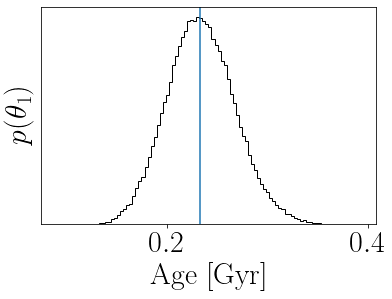

In [64]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"Age = {median_age:.2f} + {errp:.2f} - {errm:.2f} Gyr")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Now let's analyse TOI 852 in the same way.

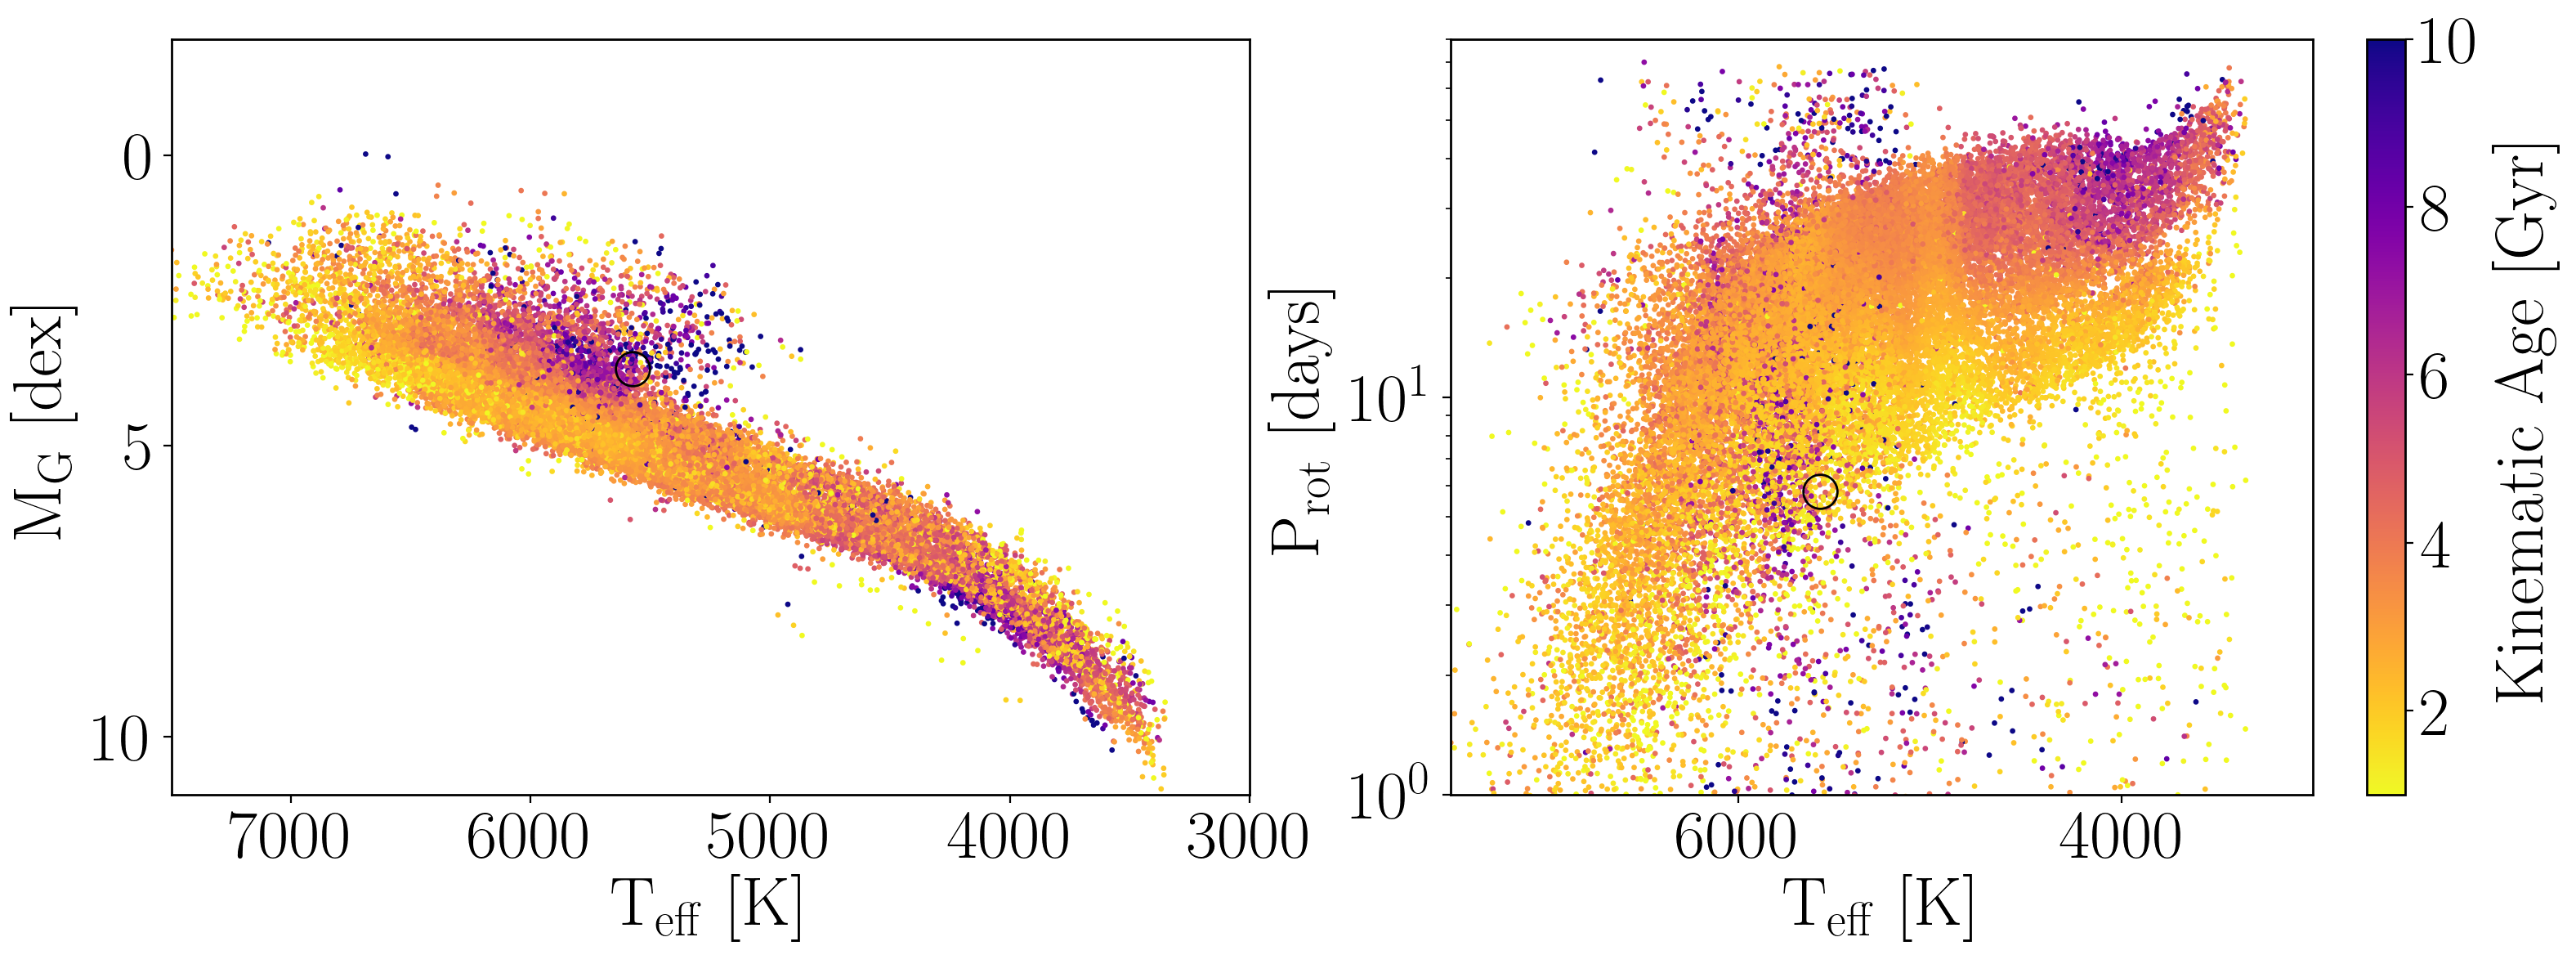

In [92]:
fig = plt.figure(figsize=(16, 6), dpi=200)

ax1 = fig.add_subplot(121)
ax1.scatter(df.teff, df.M_G, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0, label="$\mathrm{Kepler~rotators~with~kinematic~ages}$")
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.plot(toi_852.Teff, toi_852_MG, "o", color="none", mec="k", ms=15, zorder=1, linewidth=50)

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.teff, df.prot, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0, label="$\mathrm{Target~star}$")
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")
ax2.plot(toi_852.Teff, toi_852_prot, "o", color="none", mec="k", ms=15, zorder=1, linewidth=50)

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

This star lies in a part of M_G-Prot-Teff space that is populated by **kinematically old stars**. This plot is significant because it indicates that this star may be too evolved for the simple gyrochronology model used above for TOI 811.

However, it is a little borderline, so let's still go ahead and calculate an age using the Praesepe gyrochronology model.

In [65]:
ndim, nwalkers = 1, 25
log_age_init = 10
p0 = np.random.randn(nwalkers, ndim)*1e-2 + log_age_init

bprp = float(toi_852.gaiabp.values) - float(toi_852.gaiarp.values)

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[toi_852_prot, 1, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

0.32 + 0.09 - 0.09


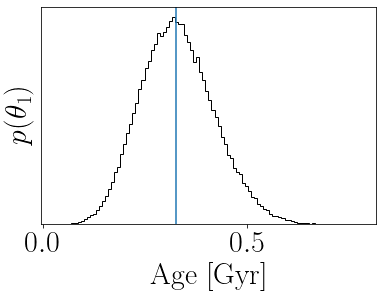

In [66]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"{median_age:.2f} + {errp:.2f} - {errm:.2f}")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

So if gyrochronology the relations can be applied to this star, then a rotation period of 5-6 days puts it at about 300 Myr. BUT to my eye, the 6 day rotation period could actually be a 12 day rotation period. How old would the star be in that case?

In [67]:
ndim, nwalkers = 1, 25
log_age_init = 10
p0 = np.random.randn(nwalkers, ndim)*1e-2 + log_age_init

bprp = float(toi_852.gaiabp.values) - float(toi_852.gaiarp.values)

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[12, 1, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

In [ ]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"{median_age:.2f} + {errp:.2f} - {errm:.2f}")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);